In [18]:
import requests
import torch
from PIL import Image
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
import matplotlib.pyplot as plt
import numpy as np


# load Mask2Former fine-tuned on COCO instance segmentation
processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-small-coco-instance")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-small-coco-instance")

/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size'
  return func(*args, **kwargs)


In [19]:
def Mask2Former_Segmentation(image):
    inputs = processor(images=image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)
    result = processor.post_process_instance_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
    predicted_instance_map = result["segmentation"]

    return predicted_instance_map.cpu().numpy()

In [47]:
import cv2

def clustering_segmentation(image, k=3):
    Z = image.reshape((-1, 3))
    Z = np.float32(Z)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, labels, centers = cv2.kmeans(Z, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    segmented_img = centers[labels.flatten()]
    segmented_img = segmented_img.reshape(image.shape)

    return segmented_img

In [49]:
def global_threshold_segmentation(image, thresh_value=127, max_value=255):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, thresh_value, max_value, cv2.THRESH_BINARY)
    return binary

In [60]:
import skimage as ski
from scipy import ndimage as ndi
def Edge_based_segmentation(image):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  edges = ski.feature.canny(gray)
  Filled = ndi.binary_fill_holes(edges)
  return Filled

In [78]:
from pycocotools.coco import COCO
import numpy as np
def Get_Image():
  coco=COCO("annotations/instances_val2017.json")
  catIds = coco.getCatIds(catNms=['person'])
  imgIds = coco.getImgIds(catIds=catIds )
  img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
  return img

In [91]:
from pycocotools.coco import COCO
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

def Get_And_Display_Image():
    coco = COCO("annotations/instances_val2017.json")
    catIds = coco.getCatIds(catNms=['cat'])
    imgIds = coco.getImgIds(catIds=catIds)
    img_info = coco.loadImgs(imgIds[np.random.randint(0, len(imgIds))])[0]
    img_url = img_info['coco_url']
    response = requests.get(img_url)
    image = Image.open(BytesIO(response.content))
    return image

In [124]:
import matplotlib.pyplot as plt
import numpy as np

def compare_segmentation_methods(image,mask2former_result,clustering_result,global_thresh_result,edge_based_result):
    # Convert results to consistent format for display
    mask2former_display = mask2former_result
    clustering_display = clustering_result
    global_thresh_display = np.stack([global_thresh_result]*3, axis=-1)  # Convert to 3-channel
    edge_based_display = np.stack([edge_based_result.astype(np.uint8)*255]*3, axis=-1)  # Convert to 3-channel

    # Create figure
    plt.figure(figsize=(20, 10))

    # Original image
    plt.subplot(2, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    # Mask2Former
    plt.subplot(2, 3, 2)
    plt.imshow(mask2former_display)
    plt.title('Mask2Former Segmentation')
    plt.axis('off')

    # Clustering
    plt.subplot(2, 3, 3)
    plt.imshow(clustering_display)
    plt.title('Clustering')
    plt.axis('off')

    # Global Threshold
    plt.subplot(2, 3, 4)
    plt.imshow(global_thresh_display)
    plt.title('Global Threshold')
    plt.axis('off')

    # Edge-based
    plt.subplot(2, 3, 5)
    plt.imshow(edge_based_display)
    plt.title('Edge-based Segmentation')
    plt.axis('off')

    # Show all results
    plt.tight_layout()
    plt.show()

loading annotations into memory...
Done (t=1.10s)
creating index...
index created!


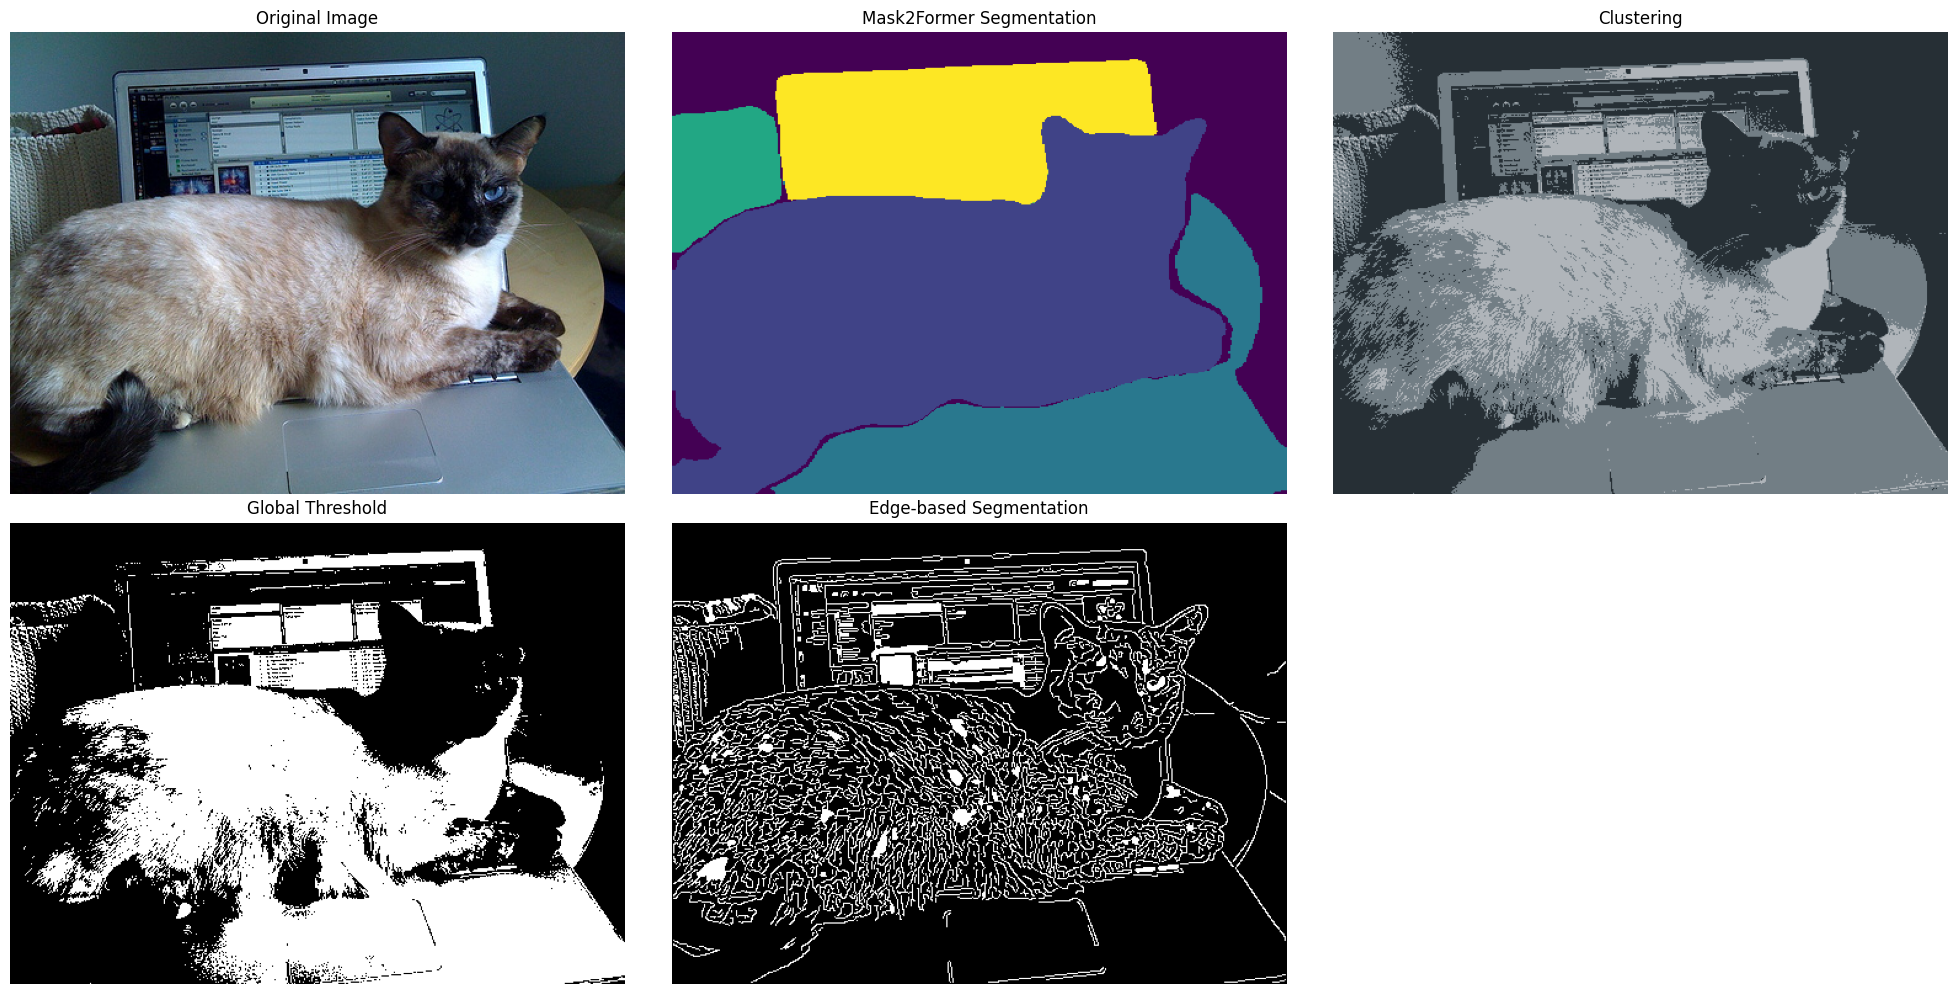

In [128]:
# Get an image using your existing function
image=Get_And_Display_Image()
# Compare segmentation methods
compare_segmentation_methods(image,Mask2Former_Segmentation(image),clustering_segmentation(np.array(image)),global_threshold_segmentation(np.array(image)),Edge_based_segmentation(np.array(image)))